STEP 1: MOUNTING GOOGLE DRIVE ON GOOGLE COLLAB

In [ ]:
#Connecting or mounting google drive on google collab to allow access to files on Google Collab
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


STEP 2: INSTALLING THE NEEDED LIBRARIES FOR FACE RECOGNITION

In [ ]:
#Installing and importing the needed libraries for the face recognition process.
!pip uninstall opencv-python
!pip install face_recognition
!pip install os-sys
!pip install opencv-python
#==4.1.2.30
!pip install cmake
!pip install dlib
!pip install wheel
import cv2
import numpy as np
import face_recognition
import os
import sys
from datetime import datetime
import dlib


STEP 3: IMPORTING IMAGES INTO A LIST, THEIR CLASSNAMES INTO A LIST, AND DISPLAYING THE PICTURES WORKING WITH

['Jack-Ma.jpg', 'Bill Gates.jpg', 'James.jpg', 'Alvin.JPG', 'Elon.jpg']


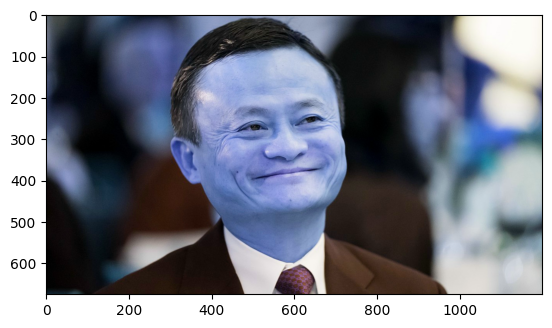

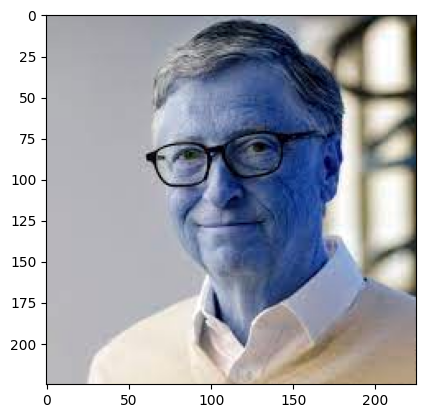

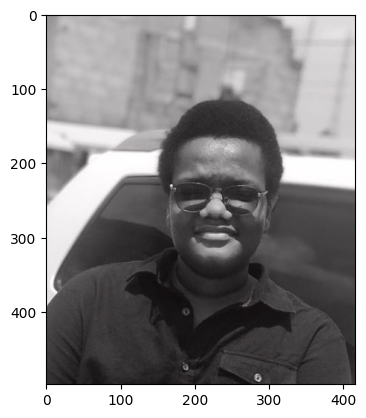

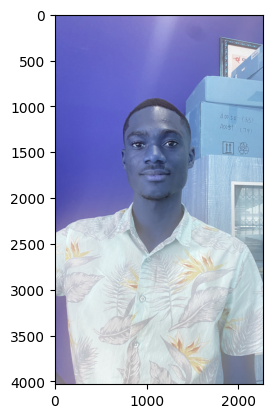

In [ ]:
import wheel
import matplotlib.pyplot as plt
#importing images
path= '/content/gdrive/MyDrive/FacePics'
images=[] #List for all images we will be working with
classPeople = [] #List for the names of the pictures we are working with
myList= os.listdir(path) #Listing all the images in my path folder
print(myList)

for cl in myList:
    curImg= cv2.imread(f'{path}/{cl}')  #importing images within the FacePics folder one by one
    images.append(curImg)
    classPeople.append(os.path.splitext(cl)[0])   #to create a list of the people without the file extensions

#Displaying first image in our images list
plt.imshow(images[0])
plt.show()
#Displaying second image in our images list
plt.imshow(images[1])
plt.show()
#Displaying third image in our images list
plt.imshow(images[2])
plt.show()
#Displaying fourth image in our images list
plt.imshow(images[3])
plt.show()

STEP 4: FINDING ENCODINGS FOR INDIVIDUAL PICTURES AND PUTTING THEM IN A LIST


In [ ]:
#creating a function to find encodings for images
#Images is a list of images we are taking into consideration
def findEncodings(images):
    encodeList=[] #List for encodings of individual images
    for img in images: #Looping through all images
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  #converting images from BGR to RGB
        encode = face_recognition.face_encodings(img)[0]
        encodeList.append(encode)
    return encodeList

#checking if funcion is working
encodeListKnown= findEncodings(images)     #finds encodings of the images in the folder(class)
print('Encoding Complete')  # just to let us know if it is done.  encoding takes time

Encoding Complete


STEP 5: FUNCTIONS TO CONVERT JAVASCRIPT OBJECT RECEIVED FROM WEBCAM INTO AN OPENCV IMAGE FOR EASY ANALYSIS AND FUNCTIONS TO CONVERT OPENCV RECTANGLE BOUNDING BOX IMAGE INTO BASE64 BYTE STRING

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

STEP 6: JAVASCRIPT CODE TO CREATE OUR LIVE VIDEO STREAM USING OUR WEBCAM AS INPUT

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

STEP 7: ATTENDANCE TAKING INTO A CSV FILE

In [ ]:
# creating a function to mark attendance
def markAttendance(name):
    with open('Attendance.csv', 'w+') as f:
        myDataList = f.readlines()
        nameList = []
        for line in myDataList:
            entry = line.split(',')  # splitting based on comma so that name and time is separated
            nameList.append(entry[0])  # appends the first portion of entry which corresponds to the person's name
        if name not in nameList:
          now = datetime.now()
          dtString = now.strftime('%H: %M: %S')
          f.writelines(f'\n {name},{dtString}')

# markAttendance('Elon')

STEP 8: STARTING STREAMING FROM WEBCAM AND APPLYING FACE RECOGNITION WHEN TRUE AND PRINTING THE FACE DISTANCES IN REGARD TO THE FACE SEEN IN THE CAMERA.

In [ ]:
from base64 import b64decode, b64encode
import PIL
import io
from google.colab.patches import cv2_imshow
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    imgScaled= cv2.resize(img, (0,0), None, 0.25, 0.25)  #scaling down image to 0.25*orig so as to reduce burden on gpu since realtime capturing
    imgScaled= cv2.cvtColor(imgScaled, cv2.COLOR_BGR2RGB)

      # nb: webcam may find more than one image at a time so we need locations
    facesCurFrame= face_recognition.face_locations(imgScaled)
    encodeCurFrame= face_recognition.face_encodings(imgScaled,facesCurFrame)   #finds encoding of webcam images

    for encodeFace,faceloc in zip(encodeCurFrame,facesCurFrame):  #one by one grabs face loc from the facescurframe list and also encodings from encode. zip was used so we can loop through both simultaneously
        matches= face_recognition.compare_faces(encodeListKnown, encodeFace)  #comparing faces between those we know already in the class and then each face got from webcam
        faceDis= face_recognition.face_distance(encodeListKnown, encodeFace)  #output is also a list since we passed in a list. the one with the lowest value is the required face
        #print(faceDis)   #gives a list of distances
        matchIndex= np.argmin(faceDis)   #gives us the index of min valued distance so we can know who we are looking for

        if matches[matchIndex]:   #if it matches any of our people
            name= classPeople[matchIndex].upper()
            #print(name)   #DONEEEEEE
            #trying to draw a rectangle around face
            y1,x2,y2,x1= faceloc
            y1, x2, y2, x1= y1*4, x2*4, y2*4, x1*4  #multiplied by 4 to undo the scaling done previously
            cv2.rectangle(img,(x1,y2-35),(x2,y2), (0,255,0), cv2.FILLED )
            cv2.putText(img,name,(x1+6,y2-6),cv2.FONT_ITALIC, 1, (255,255,255), 2 )
            markAttendance(name)

            # create transparent overlay for bounding box
            bbox_array = np.zeros([480,640,4], dtype=np.uint8)

            # get face bounding box for overlay
            y1,x2,y2,x1 = faceloc
            y1,x2,y2,x1 = y1*4,x2*4,y2*4,x1*4
            cv2.rectangle(bbox_array,(x1,y1),(x2,y2),(255,0,0),2)
            cv2.rectangle(bbox_array,(x1,y2-35),(x2,y2), (255,0,0), cv2.FILLED )
            cv2.putText(bbox_array,name,(x1+6,y2-6),cv2.FONT_ITALIC, 1, (255,255,255), 2 )

            bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
            # convert overlay of bbox into bytes
            bbox_bytes = bbox_to_bytes(bbox_array)
            # update bbox so next frame gets new overlay
            bbox = bbox_bytes

<IPython.core.display.Javascript object>